# Udacity Project #  
### By Mayank Bhatnagar ###

This project is about ‘Fine-Grained Categorization’. The technique is advance compared to object identification problems. We can use such techniques to recognize different species of flowers, birds or any other species. It has wider use in identifying and grouping objects and even evaluating whether we are finding a new species next existing or explored earlier.

## 1. Understanding Input Data and Loading Data Set ##
#### Key Import Statements ####

In [1]:
## Main Import statements
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt 
import time
%matplotlib inline

## Loading data set
from sklearn.datasets import load_files       
from keras.utils import np_utils
from glob import glob

Using TensorFlow backend.


#### Summary of Data Set used in the project ####

In [2]:
## Define function to read content of a text file
def load_file(name):
    rows = pd.read_csv(name, sep=",")
    return rows

In [3]:
## Load the information for all the loaded data set
rows = load_file('monkey_labels.csv')
## Print all the training and validation data summary
print (rows)

  Label             Latin Name                Common Name  Train Images  \
0    n0      alouatta_palliata             mantled_howler           131   
1    n1     erythrocebus_patas               patas_monkey           139   
2    n2         cacajao_calvus                bald_uakari           137   
3    n3         macaca_fuscata           japanese_macaque           152   
4    n4        cebuella_pygmea             pygmy_marmoset           131   
5    n5        cebus_capucinus      white_headed_capuchin           141   
6    n6        mico_argentatus           silvery_marmoset           132   
7    n7       saimiri_sciureus     common_squirrel_monkey           142   
8    n8        aotus_nigriceps  black_headed_night_monkey           133   
9    n9  trachypithecus_johnii             nilgiri_langur           132   

   Validation Images  
0                 26  
1                 28  
2                 27  
3                 30  
4                 26  
5                 28  
6            

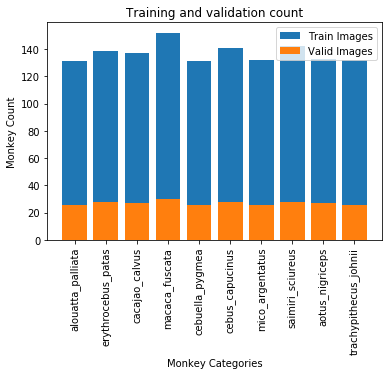

In [4]:
## Presenting the data in a graphical format

plt.title('Training and validation count')
index = np.arange(len(rows))
plt.bar(index, rows['Train Images'], label='Train Images')
plt.bar(index, rows['Validation Images'], label='Valid Images')
plt.xlabel('Monkey Categories', fontsize=10)
plt.ylabel('Monkey Count', fontsize=10)
plt.xticks(index, rows['Latin Name'], fontsize=10, rotation=90)
plt.legend(loc=1)

plt.show()

#### Load of Data Set ####

In [5]:
## define function to load training and validation datasets
def load_dataset(path):
    data = load_files(path)
    mon_files = np.array(data['filenames'])
    ## print(mon_files)
    
    """
    y = data['target']
    n = y.shape[0]
    print(y,n)
    cate = np.zeros((272,11),dtype=np.int)
    print(cate)
    print(len(cate))
    print(np.arange((n)))
    print(cate[np.arange(n), y])
    cate[np.arange(n), y] = 0
    """
    
    ## Check Below
    mon_targets = np_utils.to_categorical(np.array(data['target']),11)
    return mon_files, mon_targets

In [6]:
## load train and validation datasets
train_files, train_targets = load_dataset('./training')
valid_files, valid_targets = load_dataset('./validation')

## load list of monkey names
mon_cate = [item[11:-1] for item in sorted(glob("./training/*/"))]
mon_name = []

for idx, item in enumerate(mon_cate):
    ## print(rows.loc[rows['Label'] == item, 'Latin Name'].iloc[0])
    mon_name.append(rows[rows['Label']== item]['Latin Name'].iloc[0])

## print statistics about the dataset
print('There are %d total monkey categories.\n' % len(mon_cate))
print('%s \n' % rows['Latin Name'].iloc[0:len(mon_cate)])
print('There are %s total monkey images.' % len(np.hstack([train_files, valid_files])))
print('There are %d training monkey images.' % len(train_files))
print('There are %d validation monkey images.' % len(valid_files))

There are 10 total monkey categories.

0        alouatta_palliata
1       erythrocebus_patas
2           cacajao_calvus
3           macaca_fuscata
4          cebuella_pygmea
5          cebus_capucinus
6          mico_argentatus
7         saimiri_sciureus
8          aotus_nigriceps
9    trachypithecus_johnii
Name: Latin Name, dtype: object 

There are 1365 total monkey images.
There are 1093 training monkey images.
There are 272 validation monkey images.


## 2. Pre-Processing of Data ##

In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    ## loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    ## convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    ## convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
## display the image, along with bounding box
## plt.imshow(cv_rgb)
## plt.show()

In [8]:
## Rescaling the images between 0 and 1
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

## pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255

100%|██████████| 272/272 [00:08<00:00, 31.38it/s]


## 3. Creating a Benchmark ResNet50 and VGG16 model ##

In [9]:
## Common functions for Creating Benchmarking

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras import backend

from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD

from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16

### Creating ResNET50 model using three modularized functions ###

1. ResNet50_mod => Create ResNet50 model
2. train_model => Train the created model
3. create_graph => Plot Accuracy and Loss functions


In [10]:
## Creating a ResNet50 Model after clearing session
def ResNet50_mod():
    
    ## To clear memory from the model. Remove the comment and run.
    backend.clear_session()
    
    ## To create a new model
    ResNet50_model = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3),  pooling='avg')
    x = ResNet50_model.output
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(11, activation='softmax', name='custom_output')(x) ## Need to check why it can't be 10
    ResNet50_T_model = Model(inputs=ResNet50_model.input, outputs = output)

    ## Suppressing retraining of already trained model
    for layer in ResNet50_model.layers:
        layer.trainable = False
    
    ## Compiling the model
    ResNet50_T_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    ## Checking how does the complie process work with Adm optimizer
    ## ResNet50_T_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return ResNet50_T_model

In [11]:
## This is an additional logic
def train_model(model, epochs_val, batch_val):

    acc = []
    val_acc = []
    loss = []
    val_loss = []
    test_accu = []
    time_taken = []

    for e_val in epochs_val:
        for b_val in batch_val:
            print (e_val,' ',b_val)

            ## Calling function to create the model
            #monkey_model = monkey_mod()
            
            ## Start tracking the time
            start_time = time.time()
            
            ## Training the model and capturing the history
            model_history = model.fit(train_tensors, train_targets, 
                                validation_data=(valid_tensors, valid_targets),
                                epochs=e_val, batch_size=b_val, callbacks=None, verbose=1)

           
            ## Stop tracking the time
            end_time = time.time()
            time_taken.append(end_time - start_time)
        
            ## Capture accuracy and loss information
            acc.append(model_history.history['acc'])
            val_acc.append(model_history.history['val_acc'])
            loss.append(model_history.history['loss'])
            val_loss.append(model_history.history['val_loss'])

            ## Getting prediction and accuracy details
            mon_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in valid_tensors]

            ## report test accuracy
            test_accuracy = 100*np.sum(np.array(mon_predictions)==np.argmax(valid_targets, axis=1))/len(mon_predictions)
            print('Test accuracy: %.4f%%' % test_accuracy)
            test_accu.append(test_accuracy)
            
            ## Printing the training time taken
            print('Training Time: %s sec' % time_taken)
            
    ## Create Plot for the model
    ## create_graph(epochs_val, batch_val, acc, val_acc, loss, val_loss, test_accu)
    return (acc, val_acc, loss, val_loss, test_accu, time_taken)

In [12]:
## Plotting all the graphs together as a generic function
def create_graph(epochs_val, batch_val, acc, val_acc, loss, val_loss, test_acc, time_taken):
    
    x = 0
    ## Iterate for all the values for each epochs
    for e_val in epochs_val:
        for b_val in batch_val:
            
            plt.title('Training and validation accuracy: Epoch (' + str(e_val) + '), Batch Size (' + str(b_val) + ')')
            plt.plot(range(1,e_val+1), acc[x], 'red', label='Training acc')
            plt.plot(range(1,e_val+1), val_acc[x], 'blue', label='Validation acc')
            plt.legend()
            
            plt.figure()
            plt.title('Training and validation loss: Epoch (' + str(e_val) + '), Batch Size (' + str(b_val) + ')')
            plt.plot(range(1,e_val+1), loss[x], 'red', label='Training loss')
            plt.plot(range(1,e_val+1), val_loss[x], 'blue', label='Validation loss')
            plt.legend()
            plt.show()
            
            ## Printing accuracy information for each batch run
            print('Test Accuracy: %.4f%%' % test_accu[x])
            
            ## Printing the training time taken
            print('Training Time: %s sec' % (time_taken[x]))

            x += 1

In [13]:
### Create model and train

## Submitting with below
epochs_val = [10,20,40]
batch_val = [16,32]

## Test with below
#epochs_val = [10]
#batch_val = [32]

## Create and train the model
model = ResNet50_mod()
(acc, val_acc, loss, val_loss, test_accu, time_taken) = train_model(model, epochs_val, batch_val)

94658560/94653016 [==============================] - 1s 0us/step
10   32
Train on 1093 samples, validate on 272 samples
Epoch 1/10
1093/1093 [==============================] - 17s 15ms/step - loss: 2.1546 - acc: 0.3486 - val_loss: 2.4907 - val_acc: 0.0956
Epoch 2/10
1093/1093 [==============================] - 14s 12ms/step - loss: 0.9100 - acc: 0.7036 - val_loss: 2.7483 - val_acc: 0.1103
Epoch 3/10
1093/1093 [==============================] - 14s 12ms/step - loss: 0.6247 - acc: 0.8033 - val_loss: 2.6517 - val_acc: 0.1103
Epoch 4/10
1093/1093 [==============================] - 14s 12ms/step - loss: 0.4053 - acc: 0.8527 - val_loss: 4.0999 - val_acc: 0.0993
Epoch 5/10
1093/1093 [==============================] - 14s 12ms/step - loss: 0.2982 - acc: 0.9030 - val_loss: 4.9871 - val_acc: 0.0956
Epoch 6/10
1093/1093 [==============================] - 14s 12ms/step - loss: 0.3901 - acc: 0.8866 - val_loss: 6.0612 - val_acc: 0.0956
Epoch 7/10
1093/1093 [==============================] - 14s 12ms

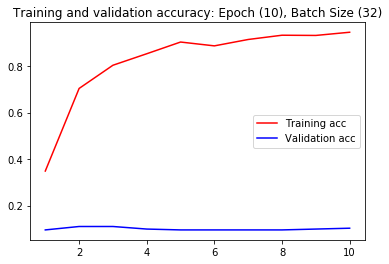

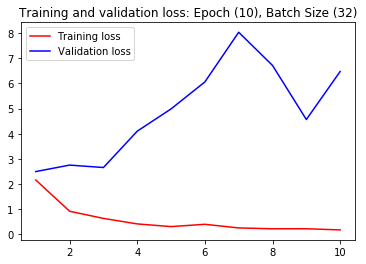

Test Accuracy: 10.2941%
Training Time: 139.49326825141907 sec


In [14]:
## Calling graph function to create graphs
create_graph(epochs_val, batch_val, acc, val_acc, loss, val_loss, test_accu, time_taken)

### Creating VGG16 model using three modularized functions ###

#### Created New Function
1. VGG16_mod => Create VGG16 model

#### Used Existing Function
2. train_model => Train the created model
3. create_graph => Plot Accuracy and Loss functions

In [15]:
## Creating a ResNet50 Model after clearing session
def VGG16_mod():
    
    ## To clear memory from the model. Remove the comment and run.
    backend.clear_session()
    
    ## To create a new model
    VGG16_model = VGG16(weights='imagenet')
    x = VGG16_model.output
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(11, activation='softmax', name='custom_output')(x) ## Check why it can't be 10
    VGG16_T_model = Model(inputs=VGG16_model.input, outputs = output)
    
    ## Suppressing retraining of already trained model
    for layer in VGG16_model.layers:
        layer.trainable = False

    ## Compiling the model
    VGG16_T_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    ## Checking how does the complie process work with Adm optimizer
    ## ResNet50_T_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return VGG16_T_model

In [16]:
### Create model and train

## Submitting with below
epochs_val = [10,20,40]
batch_val = [16,32]

## Test with below
#epochs_val = [10]
#batch_val = [32]

## Create and train model
model = VGG16_mod()
(acc, val_acc, loss, val_loss, test_accu, time_taken) = train_model(model, epochs_val, batch_val)

553467904/553467096 [==============================] - 7s 0us/step
10   32
Train on 1093 samples, validate on 272 samples
Epoch 1/10
1093/1093 [==============================] - 27s 25ms/step - loss: 2.3544 - acc: 0.1253 - val_loss: 2.3070 - val_acc: 0.1103
Epoch 2/10
1093/1093 [==============================] - 22s 20ms/step - loss: 2.2901 - acc: 0.1308 - val_loss: 2.2599 - val_acc: 0.1765
Epoch 3/10
1093/1093 [==============================] - 22s 20ms/step - loss: 2.2401 - acc: 0.1702 - val_loss: 2.2148 - val_acc: 0.1654
Epoch 4/10
1093/1093 [==============================] - 22s 20ms/step - loss: 2.1839 - acc: 0.1812 - val_loss: 2.1578 - val_acc: 0.1728
Epoch 5/10
1093/1093 [==============================] - 22s 20ms/step - loss: 2.1594 - acc: 0.1702 - val_loss: 2.1208 - val_acc: 0.2537
Epoch 6/10
1093/1093 [==============================] - 22s 20ms/step - loss: 2.1286 - acc: 0.1848 - val_loss: 2.0937 - val_acc: 0.2169
Epoch 7/10
1093/1093 [==============================] - 22s 20

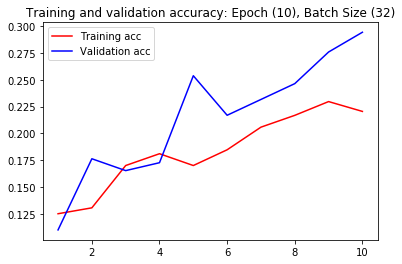

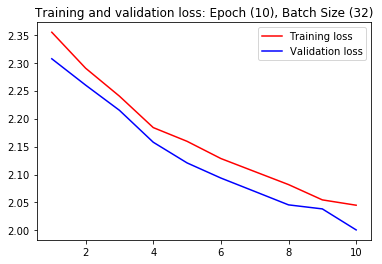

Test Accuracy: 29.4118%
Training Time: 223.27734804153442 sec


In [17]:
## Calling graph function to create graphs
create_graph(epochs_val, batch_val, acc, val_acc, loss, val_loss, test_accu, time_taken)

## 4. Creating a CNN Model from Scratch ##

Create a CNN model with initial size of 224, 224, 3. CNN model would consist of following steps:

- a. Convolutional Layer with initial Input (244, 224, 3)
- b. Max Pooling to reduce special dimension
- c. Convolutional Layer
- d. Max Pooling
- e. Dropout
- f. Dense
- g. Softmax

### Creating New model using three modularized functions ###

#### Created a New Function
1. monkey_mod => Creat new CNN model

#### Used Existing Functions
2. train_model => Train the created model
3. create_graph => Plot Accuracy and Loss functions

In [18]:
## Creating a Model from scratch after clearing session
def monkey_mod():
    
    ## To clear memory from the model. Remove the comment and run.
    backend.clear_session()
    
    ## To create a new model  
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224,224,3)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    ## Following doesn't make model efficient
    #model.add(Dropout(0.3))
    #model.add(Dense(128, activation='relu'))
    #model.add(Dropout(0.3))
    #model.add(Dense(64, activation='relu'))
    #model.add(Dropout(0.3))
    #model.add(Dense(32, activation='relu'))
    model.add(Flatten())
    model.add(Dense(11, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(11, activation='softmax'))

    ## Compiling the model
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [19]:
### Create model and train

## Submitting with below
epochs_val = [10,20,40]
batch_val = [16,32]

## Test with below
#epochs_val = [10]
#batch_val = [32]
    
model = monkey_mod()
(acc, val_acc, loss, val_loss, test_accu, time_taken) = train_model(model, epochs_val, batch_val)

10   32
Train on 1093 samples, validate on 272 samples
Epoch 1/10
1093/1093 [==============================] - 5s 4ms/step - loss: 2.4935 - acc: 0.1208 - val_loss: 2.3891 - val_acc: 0.0882
Epoch 2/10
1093/1093 [==============================] - 4s 4ms/step - loss: 2.3639 - acc: 0.1226 - val_loss: 2.3362 - val_acc: 0.1029
Epoch 3/10
1093/1093 [==============================] - 4s 4ms/step - loss: 2.3372 - acc: 0.1363 - val_loss: 2.3361 - val_acc: 0.0993
Epoch 4/10
1093/1093 [==============================] - 4s 4ms/step - loss: 2.2889 - acc: 0.1436 - val_loss: 2.3079 - val_acc: 0.1912
Epoch 5/10
1093/1093 [==============================] - 4s 4ms/step - loss: 2.2581 - acc: 0.1418 - val_loss: 2.1601 - val_acc: 0.1360
Epoch 6/10
1093/1093 [==============================] - 4s 4ms/step - loss: 2.2306 - acc: 0.1610 - val_loss: 2.2335 - val_acc: 0.1801
Epoch 7/10
1093/1093 [==============================] - 4s 4ms/step - loss: 2.1650 - acc: 0.1830 - val_loss: 2.1415 - val_acc: 0.2537
Epoch 8

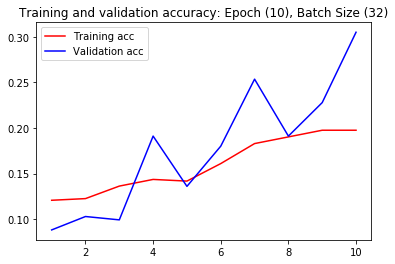

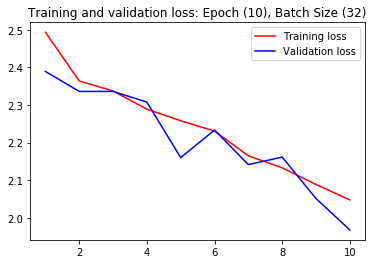

Test Accuracy: 30.5147%
Training Time: 40.71172547340393 sec


In [20]:
## Calling graph function to Plot the models
create_graph(epochs_val, batch_val, acc, val_acc, loss, val_loss, test_accu, time_taken)

####  End of Project ####
----------